(chap_transforms)=
# Image transforms

:::{admonition} Chapter outline
:class: tip

* The **watershed transform** can be used to split structures using intensity values
* The **distance transform** calculates the distance between foreground and background pixels in a binary image
* The **distance & watershed transforms** can be combined to separate round structures
:::

In [1]:
%load_ext autoreload
%autoreload 2

# Default imports
import sys
sys.path.append('../../../')
from helpers import *
from matplotlib import pyplot as plt
from myst_nb import glue
import numpy as np
from scipy import ndimage

## Introduction

An **image transform** converts an image into some other form, in which the pixel values can have a (sometimes very) different interpretation.

There are lots of ways to transform an image.
We will focus on two that are especially useful for bioimage segmentation and analysis: the distance transform and the watershed transform.
We will briefly introduce both, before then showing how they can be used in combination.

## The distance transform

The **distance transform** (sometimes called the **Euclidean distance transform**) replaces each pixel of a binary image with the distance to the closest background pixel.
If the pixel itself is already part of the background then this is zero.
The result is an image called a **distance map**.

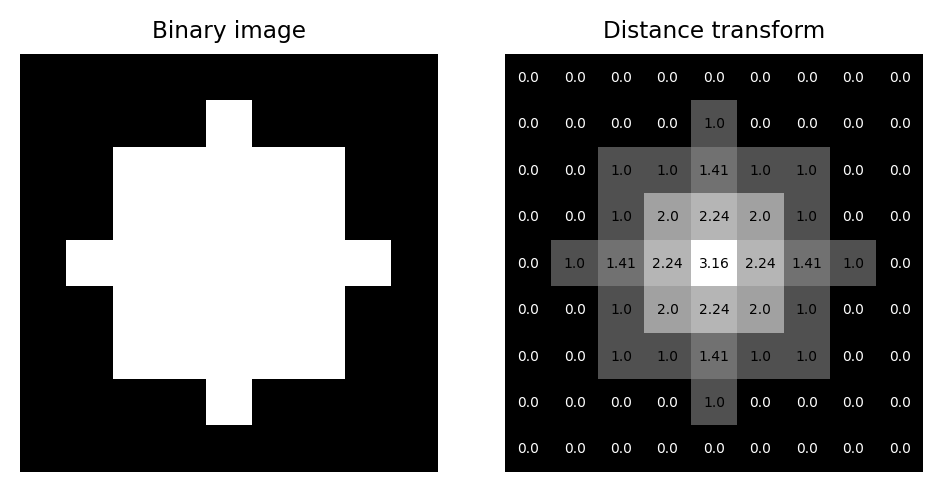

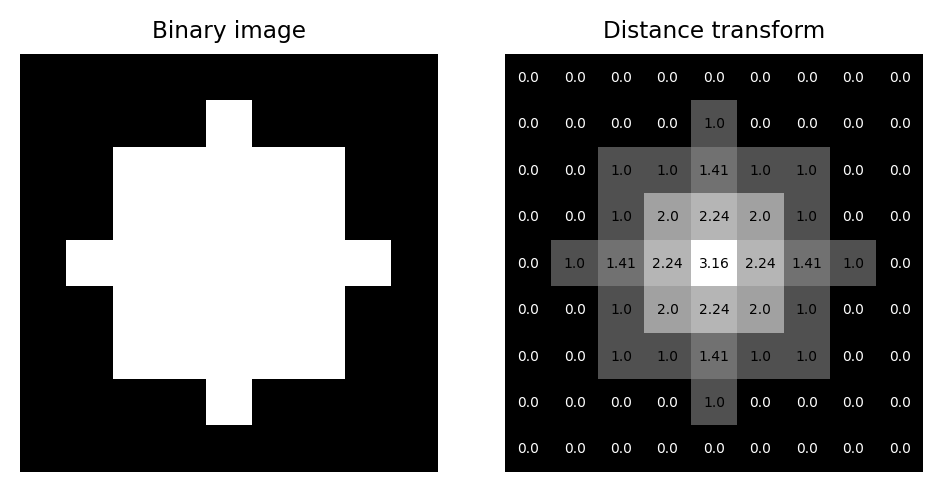

In [2]:
from scipy.ndimage import distance_transform_edt
from skimage import morphology as morph

# Create a small image
bw = np.zeros((9, 9))
bw[4, 4] = 1
bw = morph.dilation(bw, morph.disk(3))

# Compute the distance transform
im_dist = distance_transform_edt(bw)

fig = create_figure(figsize=(5, 2.5))
show_image(bw, title='Binary image', pos=121)
show_image(im_dist, title='Distance transform', pos=122)
for (i, j), z in np.ndenumerate(im_dist):
    c = 'w' if z < 1 else 'k'
    plt.text(j, i, str(round(z, 2)), color=c, ha='center', va='center', fontdict={'size': 5})

plt.tight_layout()
glue_fig('fig_morph_distance_detail', fig)

```{glue:figure} fig_morph_distance_detail
---
align: center
name: fig-morph_distance_detail
---
A binary image and its corresponding distance map, including pixel values as an overlay.
```

A natural question when considering the distance transform is: *why*?

Although its importance may not be initially obvious, we will see that creative uses of the distance transform can help solve some other problems rather elegantly.

For example, eroding or dilating binary images by a large amount can be very slow, because we have to use large maximum or minimum filters.
However, erosion and dilation can be computed from a distance map very efficiently simply by applying a global threshold.
This can be much faster in practice.

In [3]:
im = load_image('Blobs.gif')
bw = im < im.mean()

from scipy.ndimage import distance_transform_edt

im_dist = distance_transform_edt(bw)

fig = create_figure(figsize=(8, 6))
show_image(bw, title='(A) Binary image', pos=231)
show_image(im_dist, title='(B) Distance map of (A)', pos=232)
show_image(im_dist > 5, title='(C) Thresholded (B) > 5', pos=233)

im_dist_inv = distance_transform_edt(~bw)
show_image(~bw, title='(D) Binary image (inverted)', pos=234)
show_image(im_dist_inv, title='(E) Distance map of (D)', pos=235)
show_image(im_dist_inv < 5, title='(F) Thresholded (E) < 5', pos=236)

plt.tight_layout()
glue_fig('fig_morph_distance', fig)

FileNotFoundError: Blobs.gif

```{glue:figure} fig_morph_distance
---
align: center
name: fig-morph_distance
---
Implementing erosion (C) and dilation (F) of binary images by thresholding distance maps.
```

But the distance map contains useful information that we can use in other ways.

For example, we can also use distance maps to estimate the **local thickness** of a structure.
An application of this would be to assess blood vessel diameters.
If we have a binary image representing a vessel, we can generate both a distance map and a thinned binary image.
The distance map values corresponding to foreground pixels in the thinned image provide a local estimate of the vessel radius at that pixel, because the distance map gives the distance to the nearest background pixel -- and thinned pixels occur at the vessel center.

However, the distance transform can become even more useful if we combine it with other transforms.

## The watershed transform

The **watershed transform** is an example of a **region growing** method: beginning from some **seed regions**, the seeds are progressively expanded into larger regions until all the pixels of the image have been processed.
This provides an alternative to straightforward thresholding, which can be *extremely* useful when need to partition an image into many different objects.

To understand how the watershed transform works, picture the image as an uneven landscape in which the value of each pixel corresponds to a height.

In [ ]:
from matplotlib import cm

def load_watershed_image():
    im = load_image('hela-cells.zip')[:, :, 0].astype(np.float32)
    im = ndimage.gaussian_filter(im, sigma=1.5)
    im = im - ndimage.gaussian_filter(im, sigma=5)
    r = 128
    c = 75
    s = 128
    im = im[r:r+s, c:c+s]
    im = im / im.max()
    return im

# Visualize an image as a surface plot
fig = create_figure(figsize=(12, 8))
im = load_watershed_image()
show_image(im, clip_percentile=0.5, pos=131)
plt.title('Original image')

ax = fig.add_subplot(1, 3, 2, projection="3d")
X, Y = np.meshgrid(np.linspace(0, 1, im.shape[1]), np.linspace(0, 1, im.shape[0]))
ax.plot_surface(X, Y, im, color=(0.4, 0.8, 0.2), shade=True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_title('Surface plot')

ax = fig.add_subplot(1, 3, 3, projection="3d")
ax.plot_surface(X, Y, -im, color=(0.4, 0.8, 0.2))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.set_title('Inverted surface plot')

glue_fig('fig_transform_surface', fig)

```{glue:figure} fig_transform_surface
---
align: center
name: fig-transform_surface
---
Visualizing an image as a landscape, using surface plots. Higher pixel values are generally viewed as peaks, although can easily switched to become valleys by inverting the image before plotting. This may be useful when providing input to the watershed transform.
```

Now imagine water falling evenly upon this surface and slowly flooding it.
The water gathers first in the deepest parts; that is, in the places where pixels have values lower than all their neighbors.
These define the **seeds** of the watershed transform; we can think of them as separate water basins.

As the water level rises across the image, occasionally it will reach a ridge between two basins -- and, in reality, water could spill from one basin into the other.
However, in the watershed transform this is not permitted; rather a dam is constructed at such ridges.
The water then continues to rise, with dams being built as needed, until in the end every pixel is either part of a basin or a ridge, and there are exactly the same number of basins afterwards as there were at first.

The operation of the watershed transform is illustrated in the video below and example output shown in {numref}`fig-transform_surface_watershed`.

<video autoplay loop playsinline controls muted>
  <source src="../../../_static/videos/watershed.mp4" type="video/mp4">
</video>

<!-- <div class=video-container>
<iframe width="1042" height="586" src="https://www.youtube.com/embed/yywoAgJzje8?loop=1&playlist=yywoAgJzje8&modestbranding=1" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>
</div> -->

In [ ]:
from skimage.color import label2rgb
from skimage.segmentation import watershed
from skimage.filters import threshold_triangle
from skimage.morphology.extrema import local_minima

im = load_watershed_image()
bw_mask = im > threshold_triangle(im)

# lab_seeds, n = ndimage.label(morph.h_maxima(im, im.std()/3.0))
lab_seeds, n = ndimage.label(local_minima(-im))
lab_watershed = watershed(-im, markers=None, watershed_line=True)
lab_watershed_masked = watershed(-im, markers=None, mask=bw_mask, watershed_line=True)

im2 = im - np.percentile(im, 0.25)
im2 = im2 / np.percentile(im2, 99.75)
im2 = np.clip(im2, 0, 1)

fig = create_figure(figsize=(12, 12))
show_image(label2rgb(lab_seeds, image=im2, bg_label=0, alpha=0.6), pos=221)
plt.title('Image with seeds')
show_image(label2rgb(lab_watershed, image=im2, bg_label=0), pos=222)
plt.title('Full watershed segmentation')
show_image(bw_mask, pos=223)
plt.title('Binary image (triangle threshold)')
show_image(label2rgb(lab_watershed_masked, image=im2, bg_label=0), pos=224)
plt.title('Masked watershed segmentation')

glue_fig('fig_transform_surface_watershed', fig)

```{glue:figure} fig_transform_surface_watershed
---
align: center
name: fig-transform_surface_watershed
---
Applying the watershed transform to an image. Here, we passed the inverted image to the watershed transform because we want to identify bright spots rather than dark ones. The full watershed transform will expand the seeds to create a labeled image including all pixels, but we can optionally mask the expansion to prevent it filling the background. Here, we defined the mask by applying a global threshold using the triangle method. Note that the masked watershed segmentation is able to split some spots that were merged using the global threshold alone.
```

Crucially, as the seeds are expanded during the watershed transform, regions are not allowed to overlap.
Furthermore, once a pixel has been assigned to a region then it cannot be moved to become part of any other region.

Using the 'rain falling on a surface' analogy, the seeds would be **regional minima** in an image, i.e. pixels with values that are lower than all neighboring pixels.
This is where the water would gather first.

In practice, we often need to have more control over the seeds rather than accepting all regional minima (to see why too many local minima could be a problem, observe that {numref}`fig-transform_surface_watershed` contains more regions that we probably would want).
This variation is called the **seeded watershed transform**: the idea is the same, but we simply provide the seeds explicitly in the form of a labeled image, and the regions grow from these.
We can generate seeds using other processing steps, such as by identifying [H-minima](sec_h_extrema).

## Combining transforms

The watershed transform can be applied to any image, but it has some particularly interesting applications when it is applied to an image that is a distance map.

### Splitting round objects

A distance map has regional maxima whenever a foreground pixel is further from the background than any of its neighbors.

This tends to occur towards the center of objects: particularly round objects that don't contain any holes.
Importantly, regional maxima can still be present even if the 'round objects' are connected to one another in the binary image used to generate the distance map originally.

This means that by applying a watershed transform to a distance map, we are able to split 'roundish' structures in binary images.
The process is as follows:

* Compute the distance map of the image
* Invert the distance map (e.g. multiply by -1), so that peaks become valleys
* Apply the watershed transform, starting from the regional minima of the inverted distance map

In [ ]:
from skimage.morphology import disk, dilation
from skimage.segmentation import watershed

bw = np.zeros((75, 99), dtype=bool)
bw[37, 30] = True
bw[37, -30] = True
strel = disk(22)

bw = dilation(bw, strel)
im_dist = distance_transform_edt(bw)
lab = watershed(-im_dist, markers=None, mask=bw, watershed_line=True)

fig = create_figure(figsize=(8, 4))
show_image(bw, title='(A) Binary image', pos=131)
show_image(im_dist, title='(B) Distance map of (A)', pos=132)
show_image(lab > 0, title='(C) Watershed split of (B)', pos=133)

glue_fig('fig_morph_distance_split_small', fig)

```{glue:figure} fig_morph_distance_split_small
---
align: center
name: fig-morph_distance_split_small
---
Splitting round objects using the distance and watershed transforms.
```

The objects to be split do not have to be perfectly round.
The only requirement is that there are clearly distinct regional maxima in the distance transform -- or, alternatively, we can define suitable seeds using other processing steps.

In [ ]:
from scipy.ndimage import distance_transform_edt, label
from skimage.color import label2rgb
from skimage import filters

im = load_image('Blobs.gif')
bw = im < im.mean()

im_dist = distance_transform_edt(bw)
im_dist = np.round(im_dist)

# Defining the seeds is quite tricky, because there can be lots of tiny maxima
# Here, we use H-maxima to find only the larger maxima.
# We then still need to dilate them slightly to ensure maxima within the same
# blob are connected, to avoid having too many seeds.
from skimage.morphology import extrema
# bw_maxima = im_dist == ndimage.maximum_filter(im_dist, size=(5, 5))
bw_maxima = extrema.h_maxima(im_dist, 0.5)
bw_maxima = ndimage.binary_dilation(bw_maxima)
bw_maxima = bw_maxima & bw           # Make sure we didn't dilate beyond the original binary mask
lab_seeds, n = label(bw_maxima)

fig = create_figure(figsize=(8, 6))
show_image(bw, title='(A) Binary image', pos=221)
show_image(im_dist, title='(B) Distance map from', pos=222)
show_image(label2rgb(lab_seeds, bg_label=0), title='(C) Seed labels from (B)', pos=223)

lab2 = watershed(-im_dist, markers=lab_seeds, mask=bw, watershed_line=True)
show_image(label2rgb(lab2, bg_label=0), title='(E) Watershed from (C, A)', pos=224)


plt.tight_layout()
glue_fig('fig_morph_distance_split', fig)

```{glue:figure} fig_morph_distance_split
---
align: center
name: fig-morph_distance_split
---
Splitting merged blobs based on 'roundness' using the distance and watershed transforms.
Because there are many small regional maxima in the distance transform, here we define seeds using H-maxima followed by a 3×3 dilation to avoid excessive splitting.
```

:::{admonition} Watershed lines
:class: tip

When applying a watershed transform, it is often possible to specify whether the separations between regions are assigned one of the region labels, or are left as background pixels.

Here, we have shown the separations as background pixels.
This is consistent with how ImageJ's default watershed command works, and also makes the splits clearer in the figures shown here.
In Python code using scikit-image, that means we are using the `watershed_lines=True` option.
:::

### Partitioning images with Voronoi

Calculating the distance transform of an *inverted* binary image gives a distance map in which each pixel gives the distance to the closest foreground object.

If we apply a watershed transform to this distance map, using the objects in the binary image as seeds, we effectively partition the image into different regions according to the closest object in the binary image.

This is sometimes called the **Voronoi transform** of the image.

In [ ]:
from scipy.ndimage import distance_transform_edt, label
from skimage.segmentation import watershed
from skimage.color import label2rgb

im = load_image('Blobs.gif')
bw = im < im.mean()
lab, n = label(bw)

im_dist_inv = distance_transform_edt(~bw)
bw_dilated = (im_dist_inv < 10)

fig = create_figure(figsize=(6, 6))
show_image(bw, title='(A) Binary image', pos=221)
show_image(label2rgb(lab, bg_label=0), title='(B) Seed labels from (A)', pos=222)
show_image(im_dist_inv, title='(C) Distance map from (A, inverted)', pos=223)
lab2 = watershed(im_dist_inv, lab, watershed_line=True)
show_image(label2rgb(lab2, bg_label=0), title='(D) Watershed from (B, C)', pos=224)

plt.tight_layout()
glue_fig('fig_morph_voronoi_expand', fig)

```{glue:figure} fig_morph_voronoi_expand
---
align: center
name: fig-morph_voronoi_expand
---
Expanding blobs to compute the Voronoi transform of a labeled image, partitioning it into different regions according to the closest seed object.
```

### Expanding without overlaps

Building upon the Vononoi idea in the last section, we can expand the objects themselves in such a way that they don't overlap.

```{figure} images/qupath_cells.png
---
figclass: margin
---
QuPath's cell detection, based upon nucleus detection + watershed expansion.
```

Our goal is to dilate each object in the image by 10 pixels, but without merging.
If seed objects are closer than 20 pixels apart, they each expand the same amount -- until they meet in the middle.
This technique may be used to approximate a cell boundary based upon detected nuclei by expansion using a fixed distance.

Firstly, we look at what *won't* work.
We can't simply dilate a labeled image with a maximum filter, because there's nothing to prevent regions merging into one another.
When seeds are close together, the higher label will 'win' the expansion race in every case, dominating the output.

In [ ]:
from scipy.ndimage import distance_transform_edt, label
from skimage.segmentation import watershed
from skimage.color import label2rgb

im = load_image('Blobs.gif')
bw = im < im.mean()
lab, n = label(bw)
lab_dilated = morph.dilation(lab, disk(10))

fig = create_figure(figsize=(8, 6))
show_image(label2rgb(lab, bg_label=0), title='(A) Seed labels from (A)', pos=131)
show_image(label2rgb(lab_dilated, bg_label=0), title='(B) Seeds expanded by dilation', pos=132)
show_image(label2rgb(lab, bg_label=0), title='(C) Overlay of (A) and (B)', pos=133)
show_image(label2rgb(lab_dilated, bg_label=0), alpha=0.5, title='(C) Overlay of (A) and (B)')

plt.tight_layout()
glue_fig('fig_morph_bad_expand', fig)

```{glue:figure} fig_morph_bad_expand
---
align: center
name: fig-morph_bad_expand
---
Expanding blobs using a maximum filter only. This approach is too simple; it results in overlapping labels and a lot of confusion.
```

Instead, we need to build upon the Voronoi approach shown in {numref}`fig-morph_voronoi_expand`.
The only difference we need to incorporate is that we prevent the watershed expansion from growing beyond 10 pixels.

Fortunately, this criterion is easy to set: our distance map already gives us the distance to every seed object.
We can threshold that to define a binary mask that indicates where regions should no longer expand.
If we update our watershed output to have background pixels at the same locations where our binary mask has background pixels, we have achieved a constrained expansion of 10 pixels without overlap.

In [ ]:
from scipy.ndimage import distance_transform_edt, label
from skimage.segmentation import watershed
from skimage.color import label2rgb

im = load_image('Blobs.gif')
bw = im < im.mean()
lab, n = label(bw)

im_dist_inv = distance_transform_edt(~bw)
bw_dilated = (im_dist_inv < 10)

fig = create_figure(figsize=(8, 6))
show_image(bw, title='(A) Binary image', pos=231)
show_image(label2rgb(lab, bg_label=0), title='(B) Seed labels from (A)', pos=232)
show_image(im_dist_inv, title='(C) Distance map from (A, inverted)', pos=233)

show_image(bw_dilated, title='(D) Thresholded (C) < 10', pos=234)

lab2 = watershed(im_dist_inv, lab, mask=bw_dilated, watershed_line=True)
show_image(label2rgb(lab2, bg_label=0), title='(E) Masked watershed from (B, C, D)', pos=235)
lab2[~bw_dilated] = 0

show_image(label2rgb(lab, bg_label=0), title='(F) Expanded seeds', pos=236)
show_image(label2rgb(lab2, bg_label=0), alpha=0.5, title='(F) Expanded seeds')

plt.tight_layout()
glue_fig('fig_morph_distance_expand', fig)

```{glue:figure} fig_morph_distance_expand
---
align: center
name: fig-morph_distance_expand
---
Using distance and watershed transforms to expand regions by a fixed distance, without overlap. The final output (F) is obtained using information from all images (A) - (E).
```